In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random
from tqdm.notebook import tqdm, trange
import pickle as pkl
%load_ext autoreload
%autoreload 2

In [2]:
# Erstellt August 2020
# (c) mha

def create_sea(seed=None):
    'Creates a sea with random ships on it'
    rng = random.Random(seed)
    sea = np.zeros((10,10))
    #for l in [5, 4, 3, 2]: # Länge
    for l in [5,4,3,2]: # Länge
        n = 6-l # Anzahl
        for _ in range(n):
            # Boot mit Länge l platzieren
            while True:
                t = rng.random() < 0.5
                if t: sea = sea.T # Transponieren
                px = rng.randint(0, 10-l)
                py = rng.randint(0, 9)
                if sum(sea[px:px+l,py]) > 0:
                    continue
                sea[px:px+l, py] = 1
                if t: sea = sea.T # Transponieren
                break
    return sea

def create_detection(seed=None, l=5):
    'Creates a random detected array (for test purposes)'
    rng = random.Random(seed)
    det = np.zeros((10,10))
    px = rng.randint(0, 10-l)
    py = rng.randint(0, 9)
    det[px:px+l, py] = 1
    
    if rng.random() < 0.5: 
        det = det.T
    return det

def visualize(sea, detection):
    'Erstellt eine Veranschaulichung, 0 bzw. 4 sind detektiertes Wasser bzw. Schiff, 1 und 2 sind undetektiert.'
    return sea + sea*detection + 1 - ((1-sea)*detection)

def plot_sea(sea, det, ax=None):
    if ax is None: ax = plt.gca()
    #ax.imshow(visualize(sea, det), vmin=-2, cmap='plasma')
    ax.imshow(visualize(sea, det), vmin=-1, vmax=3.15, cmap='cividis')
    ax.axis('off')

In [3]:
from numba import njit, jit

@njit(cache=True)
def njit_create_sea():
    'Creates a sea with random ships on it'
    sea = np.zeros((10,10))
    for l in [5,4,3,2]: # Länge
        n = 6-l # Anzahl
        for _ in range(n):
            # Boot mit Länge l platzieren
            while True:
                t = np.random.rand() < 0.5
                if t: sea = sea.T # Transponieren
                px = np.random.randint(0, 11-l)
                py = np.random.randint(0, 10)
                if np.sum(sea[px:px+l,py]) > 0:
                    continue
                sea[px:px+l, py] = 1
                if t: sea = sea.T # Transponieren
                break
    return sea

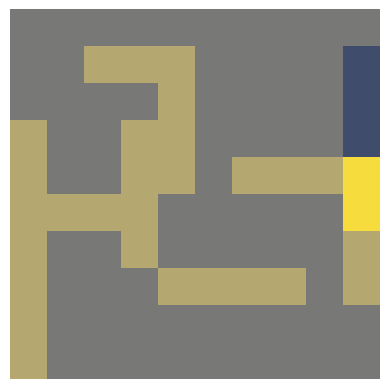

In [4]:
sea = create_sea(0)
#detection = np.zeros((10,10))
#detection[4, 0:5] = 1.
det = create_detection(l=5, seed=1)
###detected = detect(sea, det)

plt.imshow(sea*255)
plot_sea(sea, det)

### Modell trainieren

In [5]:
def encode_x(sea, det):
    'Encodes the visible information to an input to the neural network'
    return np.stack([(1-sea)*det, (1-det), sea*det], -1)
    

def batchgen(size=50):
    while True:
        xs, ys = [], []
        for _ in range(size):
            sea = njit_create_sea()
            r = np.random.rand()
            if r < 0.25:
                det = np.random.rand(10,10) < np.random.rand()
            elif r < 0.5:
                det = np.random.rand(10,10) < 1/30*np.random.rand()
            elif r < 0.75:
                det = np.random.rand(10,10) < 1/6*np.random.rand()
            else:
                det = np.random.rand(10,10) < 0.5*np.random.rand()
            x = encode_x(sea, det)
            xs.append(x)
            ys.append(sea.reshape((10,10,1)))
        yield np.array(xs), np.array(ys)
        

In [6]:
import torch
from torch import nn
from utils import *

In [7]:
relu = torch.nn.ReLU()
sigmoid = torch.nn.Sigmoid()

class bship_nnet(nn.Module):
    def __init__(self, n=32):
        'BattleShip CNN. More than 1 blocks didnt make a difference.'
        super().__init__()
        self.body = \
        self.dense1 = nn.Linear(3*10*10, 512)
        self.dense2 = nn.Linear(512, 100)
        
    def forward(self, x):
        # NHWC zu NCHW
        x = x.reshape(-1, 3*10*10)
        x = relu(self.dense1(x))
        x = self.dense2(x)
        return x.reshape(-1, 10, 10, 1)
    
    def predict(self, x):
        'Takes a numpy array and give out one, i. e. 10x10 -> 10x10'
        x = np2t(x[None,:])
        y = self(x)
        return t2np(y[0,:,:,0])
    
    
    
def augment(x, y):
    r = np.random.rand
    if r()<0.5:
        x, y = x.flip(1), y.flip(1)
    if r()<0.5:
        x, y = x.flip(2), y.flip(2)
    if r()<0.5:
        x, y = x.transpose(1,2), y.transpose(1,2)
    return x, y


net = bship_nnet().cuda();
optimizer = torch.optim.Adam(lr=1e-3, params=net.parameters())
net.losses = []
net.iters = 0

teacher = bship_nnet().cuda()
teacher.load_state_dict(net.state_dict());
teacher.eval();

In [8]:
with open('data/battleships_unet.dat', 'rb') as f:
    net.load_state_dict(torch.load(f))

RuntimeError: Error(s) in loading state_dict for bship_nnet:
	Missing key(s) in state_dict: "body.0.weight", "body.0.bias", "body.2.weight", "body.2.bias", "body.3.weight", "body.3.bias". 
	Unexpected key(s) in state_dict: "conv1.weight", "conv1.bias", "down1.conv_res.weight", "down1.conv_res.bias", "down1.conv1.weight", "down1.conv1.bias", "down1.conv2.weight", "down1.conv2.bias", "down1.bn_res.weight", "down1.bn_res.bias", "down1.bn_res.running_mean", "down1.bn_res.running_var", "down1.bn_res.num_batches_tracked", "down1.bn1.weight", "down1.bn1.bias", "down1.bn1.running_mean", "down1.bn1.running_var", "down1.bn1.num_batches_tracked", "down1.bn2.weight", "down1.bn2.bias", "down1.bn2.running_mean", "down1.bn2.running_var", "down1.bn2.num_batches_tracked", "down2.conv_res.weight", "down2.conv_res.bias", "down2.conv1.weight", "down2.conv1.bias", "down2.conv2.weight", "down2.conv2.bias", "down2.bn_res.weight", "down2.bn_res.bias", "down2.bn_res.running_mean", "down2.bn_res.running_var", "down2.bn_res.num_batches_tracked", "down2.bn1.weight", "down2.bn1.bias", "down2.bn1.running_mean", "down2.bn1.running_var", "down2.bn1.num_batches_tracked", "down2.bn2.weight", "down2.bn2.bias", "down2.bn2.running_mean", "down2.bn2.running_var", "down2.bn2.num_batches_tracked", "down3.conv_res.weight", "down3.conv_res.bias", "down3.conv1.weight", "down3.conv1.bias", "down3.conv2.weight", "down3.conv2.bias", "down3.bn_res.weight", "down3.bn_res.bias", "down3.bn_res.running_mean", "down3.bn_res.running_var", "down3.bn_res.num_batches_tracked", "down3.bn1.weight", "down3.bn1.bias", "down3.bn1.running_mean", "down3.bn1.running_var", "down3.bn1.num_batches_tracked", "down3.bn2.weight", "down3.bn2.bias", "down3.bn2.running_mean", "down3.bn2.running_var", "down3.bn2.num_batches_tracked", "resblock4.conv1.weight", "resblock4.conv1.bias", "resblock4.conv2.weight", "resblock4.conv2.bias", "resblock4.bn1.weight", "resblock4.bn1.bias", "resblock4.bn1.running_mean", "resblock4.bn1.running_var", "resblock4.bn1.num_batches_tracked", "resblock4.bn2.weight", "resblock4.bn2.bias", "resblock4.bn2.running_mean", "resblock4.bn2.running_var", "resblock4.bn2.num_batches_tracked", "resblock3.conv1.weight", "resblock3.conv1.bias", "resblock3.conv2.weight", "resblock3.conv2.bias", "resblock3.bn1.weight", "resblock3.bn1.bias", "resblock3.bn1.running_mean", "resblock3.bn1.running_var", "resblock3.bn1.num_batches_tracked", "resblock3.bn2.weight", "resblock3.bn2.bias", "resblock3.bn2.running_mean", "resblock3.bn2.running_var", "resblock3.bn2.num_batches_tracked", "resblock2.conv1.weight", "resblock2.conv1.bias", "resblock2.conv2.weight", "resblock2.conv2.bias", "resblock2.bn1.weight", "resblock2.bn1.bias", "resblock2.bn1.running_mean", "resblock2.bn1.running_var", "resblock2.bn1.num_batches_tracked", "resblock2.bn2.weight", "resblock2.bn2.bias", "resblock2.bn2.running_mean", "resblock2.bn2.running_var", "resblock2.bn2.num_batches_tracked", "resblock1.conv1.weight", "resblock1.conv1.bias", "resblock1.conv2.weight", "resblock1.conv2.bias", "resblock1.bn1.weight", "resblock1.bn1.bias", "resblock1.bn1.running_mean", "resblock1.bn1.running_var", "resblock1.bn1.num_batches_tracked", "resblock1.bn2.weight", "resblock1.bn2.bias", "resblock1.bn2.running_mean", "resblock1.bn2.running_var", "resblock1.bn2.num_batches_tracked", "up3.conv.weight", "up3.conv.bias", "up2.conv.weight", "up2.conv.bias", "up1.conv.weight", "up1.conv.bias", "conv_m1.weight", "conv_m1.bias". 

In [9]:
optimizer = torch.optim.Adam(lr=1e-4, params=net.parameters())
tau = 0.9
bg = batchgen(64)

In [10]:
criterion = nn.BCELoss()
MSE = nn.MSELoss()
losses = []
slosses = []

for _ in trange(400000):
    
    # Supervised Learning
    x, yt = next(bg)
    x, yt = np2t(x, yt)
    yp = net(x)
    yp = yp * x[:,:,:,[1]] + 0.5 * (1-x[:,:,:,[1]])
    raise
    loss = criterion(yp.view(-1), yt.view(-1))
    loss.backward()
    losses += [loss.item()]
        
    # Semisupervised Learning
    x, _ = next(bg)
    x = np2t(x)
    with torch.no_grad():
        y = teacher(x)
    x, y = augment(x, y)
    y2 = net(x)
    sloss = 50*MSE(y, y2)
    sloss.backward()
    slosses += [sloss.item()]
    
    optimizer.step()
    optimizer.zero_grad()
    update_mt(teacher, net, tau)
    
    if len(losses) == 100:
        #print(np.mean(losses))
        print(np.mean(slosses))
        net.losses.append((net.iters, np.mean(losses)))
        losses = []
        slosses = []
        
    if net.iters % 100 == 0:
        plt.plot(*zip(*net.losses))
        plt.ylim([0.58, 0.6])
        plt.grid()
        plt.show()
        
    if net.iters % 1000 == 0:
        with open('data/__battleships_dense.dat', 'wb') as f:
            torch.save(net.state_dict(), f)
        
    net.iters += 1
        
# 120000: tau->0.99, bs->1024, lr->1e-5

  0%|          | 0/400000 [00:00<?, ?it/s]

RuntimeError: No active exception to reraise

In [ ]:
det = create_detection()
#x = torch.from_numpy(encode_x(sea, det)[None,:].astype('float32'))
#prob = net(x)[0,:,:,0].detach().cpu().numpy()
prob = net.predict(encode_x(sea, det))
prob[det > 0] = 0
plt.imshow(visualize(sea, det))
plt.show()
plt.imshow(prob, vmax=1.)
plt.colorbar()
plt.show()

In [11]:
criterion(yp, yt)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
sea = njit_create_sea()
prob = net.predict(encode_x(sea, det))
plt.imshow(prob)

In [ ]:
sea = np.zeros((10,10))
det = np.zeros((10,10))
while np.any(1-det):
    prob = net.predict(encode_x(sea, det))
    prob[det > 0] = 0
    ij = np.random.choice(range(100), p=prob.flatten()/np.sum(prob))
    i, j = divmod(ij, 10)
    det[i,j] = 1
    sea[i,j] = 1 if np.random.rand()<prob[i,j] else 0

    #plt.imshow(visualize(sea, det))
    #plt.show()
    #plt.imshow(prob, vmax=1.)
    #plt.show()
    
plt.imshow(visualize(sea, det))

### AI spielt

In [ ]:
# gegeben: sea, model
det = np.zeros((10,10))
##det = create_detection()
i,j = [],[]


while True:
    prob = net.predict(encode_x(sea, det))
    prob[det > 0] = 0
    percent = 0. if np.sum(det)==0 else 100*np.sum(det*sea)/(np.sum(det)+1e-2)
    text = f'Hits: %d, Shots: %d, Percentage: %.1f %%' % (np.sum(det*sea), np.sum(det), percent)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
    ax1.title.set_text('Map')
    ax2.title.set_text('Neural Network prediction')
    ##fig.text(1/2,0.8, text, fontdict={})
    ax1.axis('off')
    #ax1.imshow(visualize(sea, det), vmin=0., vmax=3.)
    plot_sea(sea, det, ax1)
    ax1.scatter(j, i, c='black', alpha=1, s=150)
    ax2.axis('off')
    ax2.imshow(prob)
    #plt.title(text)
    plt.show()
    
    if np.sum(det*sea) >= np.sum(sea): break
        
    # Welchen Detektieren??
    m = prob.argmax()
    i, j = m//10, m%10
    det[i,j] = 1.

    